# Project explanation - Radio Star

## Data source

s3://radio-star-csci-e-29/unzipped/

## Hello Mr Baumgart!

Ah... look how close you are to the Harvard Club. In Boston already, working with pharmaceuticals, Trump out of office. It's a good day to be an immigrant. Save a chair for me - I'll be right over.

I'm glad we've teamed up - let's hope this project goes a little smoother than PSET-5. 

Don't worry. With your python skills and my imagination, there's nothing we can't do.

For every PSET so far, I think there has been a common set of elements. We take data, we process it, and we publish a result. The difference between this subject and other data science subjects is that in *this* subject, the methods are paramount! So as we work through this project, let's include as many of the advanced python methods we have learned as possible.

The only definites I have so far are these:

1. Our data is the Chexpert dataset which can be found in my S3 bucket

2. We will be guided in our project goals by what is beneficial to the patients.



## Chexpert dataset

### So what exactly is the chexpert dataset?

___

*From the Chexpert team*

How did we collect and label CheXpert?
CheXpert is a large public dataset for chest radiograph interpretation, consisting of 224,316 chest radiographs of 65,240 patients. We retrospectively collected the chest radiographic examinations from Stanford Hospital, performed between October 2002 and July 2017 in both inpatient and outpatient centers, along with their associated radiology reports.

Label Extraction from Radiology Reports
Each report was labeled for the presence of 14 observations as positive, negative, or uncertain. We decided on the 14 observations based on the prevalence in the reports and clinical relevance, conforming to the Fleischner Society’s recommended glossary whenever applicable. We then developed an automated rule-based labeler to extract observations from the free text radiology reports to be used as structured labels for the images.

Our labeler is set up in three distinct stages: mention extraction, mention classification, and mention aggregation. In the mention extraction stage, the labeler extracts mentions from a list of observations from the Impression section of radiology reports, which summarizes the key findings in the radiographic study. In the mention classification stage, mentions of observations are classified as negative, uncertain, or positive. In the mention aggregation stage, we use the classification for each mention of observations to arrive at a final label for the 14 observations (blank for unmentioned, 0 for negative, -1 for uncertain, and 1 for positive).

[source](https://stanfordmlgroup.github.io/competitions/chexpert/)

____

We have our raw data here

![raw](https://stanfordmlgroup.github.io/competitions/chexpert/img/figure2.png)

We have our features here.

![features](https://stanfordmlgroup.github.io/competitions/chexpert/img/table1.png)


So we have our X values, which are the images, and the Y values, which are the labels attached to the images.

Since each X value can have multiple labels attached to it, this is a **multioutput** problem.

Since each output/label can have *more than two possible classes attached to it*, this is a **multiclass** problem.

[terminology source is sklearn](https://scikit-learn.org/stable/modules/multiclass.html)

So let's take a look at what we have.

In [1]:
import pandas as pd
from PIL import Image
import os
from pathlib import Path
from matplotlib.pyplot import imshow
import numpy as np
import seaborn as sns
%matplotlib inline

## X values look like this

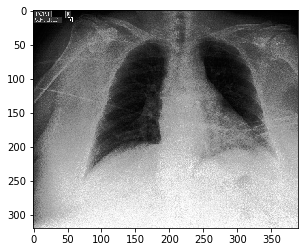

In [2]:
image_file = Path('../data/sample/patient00001/study1/view1_frontal.jpg')
im = Image.open(image_file)
imshow(im)

## Y Values look like this

In [3]:
train_file = Path('../data/sample/train.csv')
df_train = pd.read_csv(train_file)
df_train.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223414 entries, 0 to 223413
Data columns (total 19 columns):
Path                          223414 non-null object
Sex                           223414 non-null object
Age                           223414 non-null int64
Frontal/Lateral               223414 non-null object
AP/PA                         191027 non-null object
No Finding                    22381 non-null float64
Enlarged Cardiomediastinum    44839 non-null float64
Cardiomegaly                  46203 non-null float64
Lung Opacity                  117778 non-null float64
Lung Lesion                   11944 non-null float64
Edema                         85956 non-null float64
Consolidation                 70622 non-null float64
Pneumonia                     27608 non-null float64
Atelectasis                   68443 non-null float64
Pneumothorax                  78934 non-null float64
Pleural Effusion              133211 non-null float64
Pleural Other                 6492 non-n

In [5]:
df_train.nunique()

Path                          223414
Sex                                3
Age                               74
Frontal/Lateral                    2
AP/PA                              4
No Finding                         1
Enlarged Cardiomediastinum         3
Cardiomegaly                       3
Lung Opacity                       3
Lung Lesion                        3
Edema                              3
Consolidation                      3
Pneumonia                          3
Atelectasis                        3
Pneumothorax                       3
Pleural Effusion                   3
Pleural Other                      3
Fracture                           3
Support Devices                    3
dtype: int64

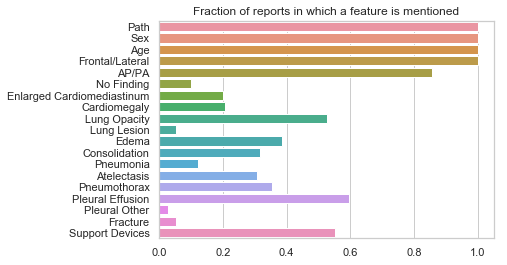

In [35]:
na_fractions = 1- df_train.isna().mean()
sns.set_theme(style="whitegrid")
ax = sns.barplot(y = na_fractions.index, x = na_fractions.values).set_title('Fraction of reports in which a feature is mentioned')

So we can see from the above that the vast majority of features that matter (i.e not age, sex, and orientation of XRay) are mentioned in only a minority of reports.

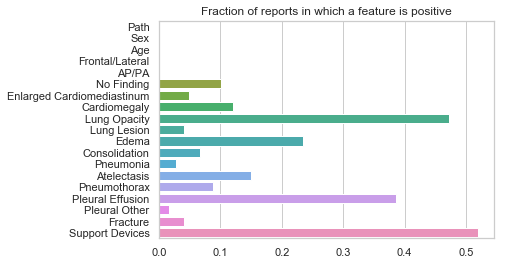

In [31]:
data = (df_train == 1).mean()
sns.set_theme(style="whitegrid")
ax = sns.barplot(y = data.index, x = data.values).set_title('Fraction of reports in which a feature is positive')

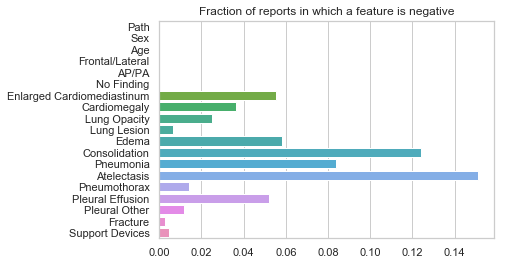

In [33]:
data = (df_train == -1).mean()
sns.set_theme(style="whitegrid")
ax = sns.barplot(y = data.index, x = data.values).set_title('Fraction of reports in which a feature is negative')

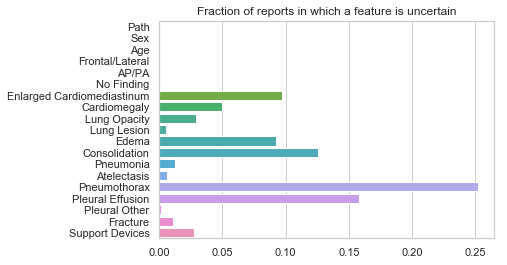

In [34]:
data = (df_train == 0).mean()
sns.set_theme(style="whitegrid")
ax = sns.barplot(y = data.index, x = data.values).set_title('Fraction of reports in which a feature is uncertain')